### 可视化<br>

#### 1数据

In [2]:
#可视化过程
%matplotlib inline
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set()
np.set_printoptions(precision=6,suppress=6)
rng = np.random.RandomState(0)    
#目标方程式
x = np.linspace(-1,1,20)
y_truth = x**4+x**3+x**2+x   #目标函数
y_gp = 2*x**2+1.266*x        #常规GP拟合结果
y_rcgp1 = 1.755*x+0.963      #改进GP第一次拟合结果
y_rcgp2 = x**2+1.48*x+0.543  #改进GP第二次拟合结果
y_rcgp3 = 1.558*x**2+1.502*x #改进GP第三次拟合结果
y_rcgp4 = x**4+x**3+x**2+x   #改进GP第四次拟合结果

target = 'Objective_Function : $x^4+x^3+x^2+x$'

data = np.loadtxt('0.5_g(0,1)_train_data.txt')
#噪声数据
noise_point = np.array([[-0.883816,  2.057998],
                        [ 0.535454,  1.468487],
                        [ 0.132867,  1.91723 ],
                        [-0.692111,  0.634919],
                        [-0.103167,  1.77405 ],
                        [-0.523579, -1.295103],
                        [-0.267056, -0.361054],
                        [ 0.555807,  1.028641],
                        [ 0.020093,  0.999243],
                        [ 0.65521 ,  1.950246]])
#正常数据
correct_point = np.array([x for x in data if x not in noise_point])
#初始随机选择的训练数据
initial_point = np.array([[ 0.813396,  2.450897],
                          [ 0.020093,  0.999243],
                          [-0.883816,  2.057998],
                          [ 0.132867 , 1.91723 ],
                          [-0.692111,  0.634919],
                          [ 0.535454,  1.468487],
                          [-0.103167 , 1.77405 ],
                          [-0.69909,  -0.313173],
                          [-0.261402, -0.206264],
                          [-0.477185, -0.306287]])

#### 可视化高斯随机数取值分布
> 数值分布在（$\mu$—2$\sigma$,$\mu$+2$\sigma$)中的概率为0.9544

Text(0.5, 1.0, '$g(0,1.0)$')

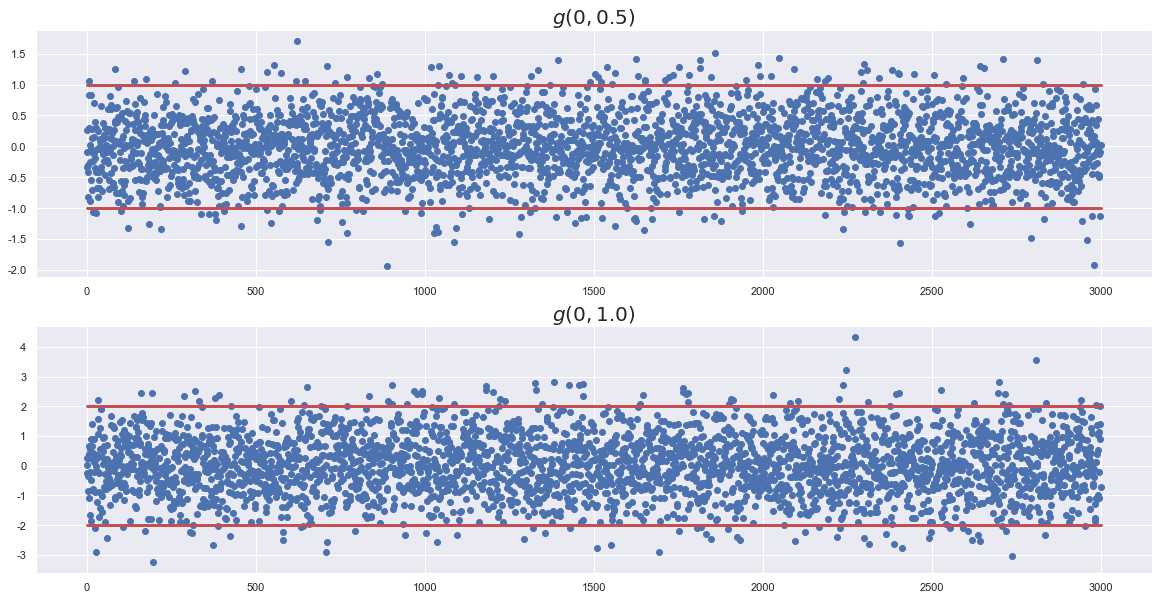

In [28]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig.subplots_adjust(wspace=0.1)
n_samples = 3000
ax[0].plot(np.random.normal(0,0.5,n_samples),'o')
ax[0].plot([0,n_samples],[1,1],'r',linewidth=3)
ax[0].plot([0,n_samples],[-1,-1],'r',linewidth=3)
ax[0].set_title('$g({},{})$'.format(0,0.5),fontsize=20)
ax[1].plot(np.random.normal(0,1,n_samples),'o')
ax[1].plot([0,n_samples],[2,2],'r',linewidth=3)
ax[1].plot([0,n_samples],[-2,-2],'r',linewidth=3)
ax[1].set_title('$g({},{})$'.format(0,1.0),fontsize=20)

In [25]:
#添加噪声
def add_noise(data,noise_rate,noise_level):
    """
    data:需要添加噪声的数据
    noise_rate:噪声率，0-1之间
    noise_rate:噪声水平，(mu,sigma)
    先得出需要添加噪声的数据量和噪声大小，然后再随机添加到原数据中。
    比如原数据有20个数据点，需要添加6个噪声点，
    则可以构造一个带部分噪声的数据（14个零和6个噪声），
    打乱噪声数据顺序后再与原数据相加
    """
    #例如 ：g = [(0,0.5),(0,1),(0,2),(0,3)]
    #噪声水平
    mu,sigma = noise_level
    #噪声数据数量
    count = int(data.shape[0]*noise_rate)
    #非噪声数据数量
    pure = data.shape[0] - count
    #定义随机高斯噪声
    noise = rng.normal(mu,sigma,size = count)    
    zero = np.zeros(pure)
    noise_data = np.concatenate((noise,zero))
    #将噪声数据打乱
    np.random.shuffle(noise_data)
    #返回加上噪声后的数据
    return data+noise_data

#### 2.可视化添加噪声后的数据

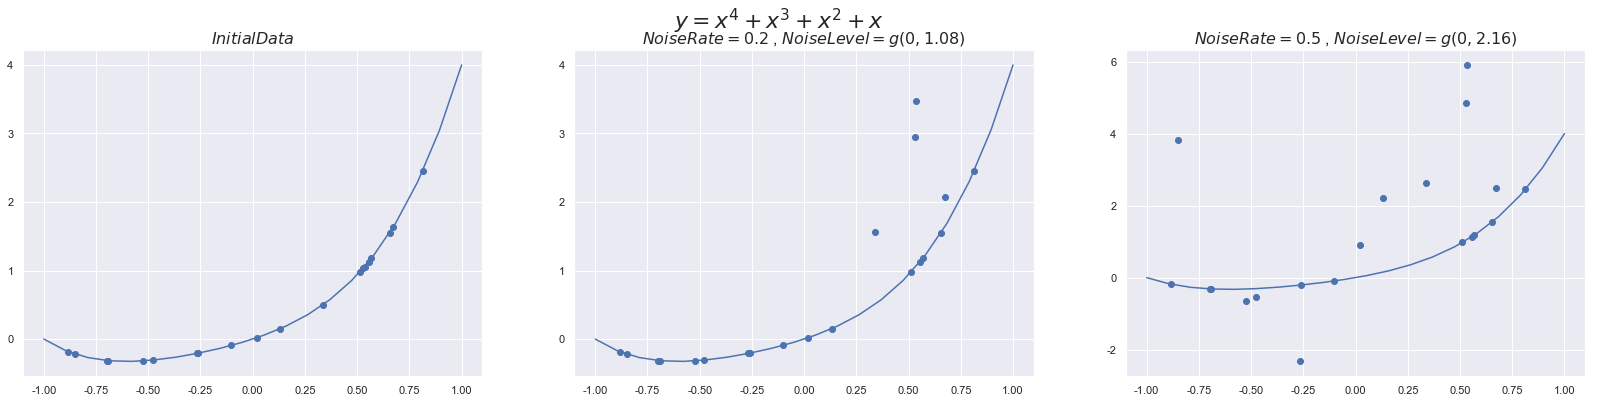

In [26]:
train_data = np.loadtxt('n2_train.txt')
data_25 = np.loadtxt('./0.2_g(0,1.08).txt')
data_50 = np.loadtxt('./0.5_g(0,2.16).txt')
fig,ax = plt.subplots(1,3,figsize=(28,6))
fig.suptitle('$y = x^4+x^3+x^2+x$',fontsize=22)

ax[0].set_title('$Initial Data$',fontsize=16)
ax[0].scatter(train_data[:,0],train_data[:,1])
ax[0].plot(x,y_truth)
ax[1].set_title('$NoiseRate = {0}$ , $NoiseLevel = g({1},{2})$'.format(0.2,0,1.08),fontsize=16)
ax[1].scatter(data_25[:,0],data_25[:,1])
ax[1].plot(x,y_truth)
ax[2].set_title('$NoiseRate = {0}$ , $NoiseLevel = g({1},{2})$'.format(0.5,0,2.16),fontsize=16)
ax[2].scatter(data_50[:,0],data_50[:,1])
ax[2].plot(x,y_truth)
fig.savefig('噪声可视化.png',dpi=300)

In [43]:
#获取离拟合结果最近的前N个数据点
def Get_the_Nearest_N_Points(formual,data,N):
    X = data[:,0]
    y = data[:,1]
    #变量符号
    x = sp.symbols('x')
    #方程
    func = sp.lambdify(x,formual,'numpy')
    #代入数据得到结果
    y_pred = func(X)
    #绝对差值
    diff = abs(y-y_pred)
    #取绝对差值最小的前N个的布尔掩码
    mask = np.where(diff < sorted(diff)[N],1,0)
    N_points = data[mask==1]
    return N_points


#### 可视化逼近过程

Text(0.5, 0, '$R^2 = 0.999999$')

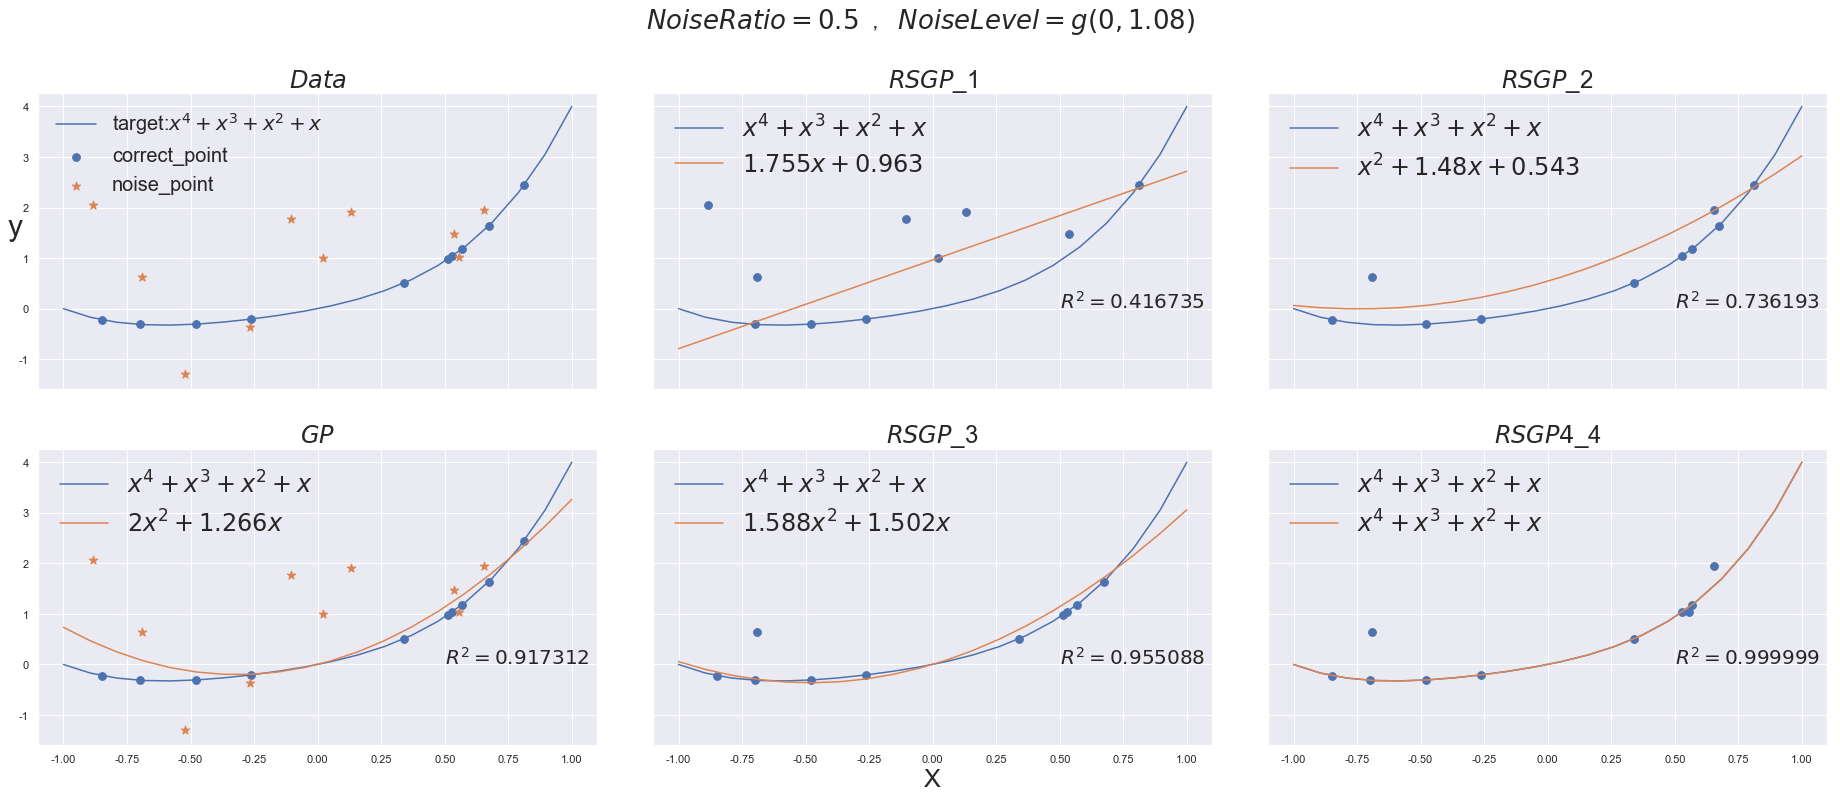

In [44]:

fig,ax = plt.subplots(2,3,figsize=(28,12),sharex='col',sharey='row')
fig.subplots_adjust(left=0.0625,right=0.95,wspace=0.1,hspace=0.2)
fmt = '$NoiseRatio = {0}$ , $NoiseLevel = g({1},{2})$'.\
    format(0.5,0,1.08)
fig.suptitle(fmt,fontproperties = 'SimHei',fontsize = 26)
#可视化初始数据
ax[0,0].set_title('$Data$',fontsize = 24)
ax[0,0].scatter(correct_point[:,0],correct_point[:,1],s=60,label='correct_point')
ax[0,0].scatter(noise_point[:,0],noise_point[:,1],s=80,marker='*',label='noise_point')
ax[0,0].plot(x,y_truth,label='target:$x^4+x^3+x^2+x$')
ax[0,0].legend(loc='upper left',fontsize=20,facecolor='none',edgecolor='none')
ax[0,0].set_ylabel('y',fontsize=30,rotation=360)

#常规GP拟合结果
ax[1,0].set_title('$GP$',fontsize = 24)
ax[1,0].scatter(correct_point[:,0],correct_point[:,1],s=60)#,label='correct_point')
ax[1,0].scatter(noise_point[:,0],noise_point[:,1],s=80,marker='*')#,label='noise_point')
ax[1,0].plot(x,y_truth,label='$x^4+x^3+x^2+x$')
ax[1,0].plot(x,y_gp,label='$2x^2+1.266x$')
ax[1,0].legend(loc='best',fontsize=24,facecolor='none',edgecolor='none')
ax[1,0].annotate('$R^2 = 0.917312$',xy = (0,1),xytext=(0.5,0),fontsize=20)

#改进GP第一次拟合结果
ax[0,1].set_title('$RSGP$_1',fontsize = 24)
ax[0,1].scatter(initial_point[:,0],initial_point[:,1],s=60)#,label='train_data')
ax[0,1].plot(x,y_truth,label='$x^4+x^3+x^2+x$')
ax[0,1].plot(x,y_rcgp1,label='$1.755x+0.963$')
ax[0,1].legend(loc='best',fontsize=24,facecolor='none',edgecolor='none')
ax[0,1].annotate('$R^2 = 0.416735$',xy = (0,1),xytext=(0.5,0),fontsize=20)

#改进GP第二次拟合结果
#离拟合结果最近的前10个数据点
N_points = Get_the_Nearest_N_Points(y_rcgp1,data,10)
ax[0,2].set_title('$RSGP$_2',fontsize = 24)
ax[0,2].scatter(N_points[:,0],N_points[:,1],s=60)#,label='train_data')
ax[0,2].plot(x,y_truth,label='$x^4+x^3+x^2+x$')
ax[0,2].plot(x,y_rcgp2,label='$x^2+1.48x+0.543$')
ax[0,2].legend(loc='best',fontsize=24,facecolor='none',edgecolor='none')
ax[0,2].annotate('$R^2 = 0.736193$',xy = (0,1),xytext=(0.5,0),fontsize=20)

#改进GP第三次拟合结果
#离拟合结果最近的前10个数据点
N_points = Get_the_Nearest_N_Points(y_rcgp2,data,10)
ax[1,1].set_title('$RSGP$_3',fontsize = 24)
ax[1,1].scatter(N_points[:,0],N_points[:,1],s=60)#,label='train_data')
ax[1,1].plot(x,y_truth,label='$x^4+x^3+x^2+x$')
ax[1,1].plot(x,y_rcgp3,label='$1.588x^2+1.502x$')
ax[1,1].legend(loc='best',fontsize=24,facecolor='none',edgecolor='none')
ax[1,1].set_xlabel('X',fontsize=25)
ax[1,1].annotate('$R^2 = 0.955088$',xy = (0,1),xytext=(0.5,0),fontsize=20)

#改进GP第四次拟合结果
#离拟合结果最近的前10个数据点
N_points = Get_the_Nearest_N_Points(y_rcgp3,data,10)
ax[1,2].set_title('$RSGP4$_4',fontsize = 24)
ax[1,2].scatter(N_points[:,0],N_points[:,1],s=60)#,label='train_data')
ax[1,2].plot(x,y_truth,label='$x^4+x^3+x^2+x$')
ax[1,2].plot(x,y_rcgp4,label='$x^4+x^3+x^2+x$')
ax[1,2].legend(loc='best',fontsize=24,facecolor='none',edgecolor='none')
ax[1,2].annotate('$R^2 = 0.999999$',xy = (0,1),xytext=(0.5,0),fontsize=20)

In [24]:
fig.savefig('分解过程.png',dpi=300)